In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

pd.set_option('max_columns', 100)

%matplotlib inline

Using TensorFlow backend.


In [2]:
COLS_SCOUTS = ['CA', 'FC', 'FS', 'GC', 'I', 'PE', 
               'RB', 'SG', 'FF', 'FD', 'G', 'DD', 
               'GS', 'A', 'FT', 'CV', 'DP', 'PP']

COL_ANSWER = ['variacao_preco']
COLS_FEATURES = ['pontos', 'preco', 'media_pontos'] + COLS_SCOUTS
COLS_EXTRA = ['id', 'rodada']
COLS_OF_INTEREST = COLS_EXTRA + COLS_FEATURES + COLS_SCOUTS + COL_ANSWER

In [35]:
df = pd.read_csv('../../data/desafio_valorizacao/valorizacao_cartola_2018.csv')
print(df.shape)

df.head()

(30955, 33)


,n,nome_completo,slug,apelido,foto,id,rodada,id_time,posicao,status,pontos,preco,variacao_preco,media_pontos,nome_time,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP
0,7,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,38,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,37,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,36,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,35,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,34,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df = df[COLS_OF_INTEREST]
print(df.shape)

df.head()

(30955, 42)


,id,rodada,pontos,preco,media_pontos,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP,variacao_preco
0,36540,38,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,36540,37,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,36540,36,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,36540,35,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,36540,34,0.0,5.74,1.55,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [37]:
df.isna().any()

id                False
rodada            False
pontos            False
preco             False
media_pontos      False
CA                 True
FC                 True
FS                 True
GC                 True
I                  True
PE                 True
RB                 True
SG                 True
FF                 True
FD                 True
G                  True
DD                 True
GS                 True
A                  True
FT                 True
CV                 True
DP                 True
PP                 True
CA                 True
FC                 True
FS                 True
GC                 True
I                  True
PE                 True
RB                 True
SG                 True
FF                 True
FD                 True
G                  True
DD                 True
GS                 True
A                  True
FT                 True
CV                 True
DP                 True
PP                 True
variacao_preco  

In [38]:
df = df.fillna(value=0)

### Ajeita scouts cumulativos

### Cria dataframe de amostras

In [33]:
%%time
df_samples = pd.DataFrame([])

for rodada in range(1, 38):
    df_rod_atual = df[df.rodada == rodada]
    df_rod_prox = df[df.rodada == (rodada - 1)]
    df_merge = df_rod_atual.merge(df_rod_prox[['id', 'variacao_preco']] , how='left', on='id', suffixes=('_anterior', '_atual'))
    df_merge = df_merge.dropna()
    df_merge = df_merge[df_merge.variacao_preco_atual > 0]
    df_samples = df_samples.append(df_merge)
    
print(df_samples.shape)

(4903, 43)
CPU times: user 482 ms, sys: 8.07 ms, total: 490 ms
Wall time: 493 ms


In [34]:
df_samples.head(10)

,id,rodada,pontos,preco,media_pontos,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP,variacao_preco_anterior,variacao_preco_atual
4,37319,2,6.14,4.47,3.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.27,0.20
8,37655,2,1.70,9.47,3.40,0.0,2.0,1.0,0.0,1.0,5.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,5.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.93,0.40
11,37662,2,0.00,9.78,6.20,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,1.78
12,37674,2,-0.10,13.00,6.25,1.0,2.0,4.0,0.0,2.0,3.0,2.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,0.0,2.0,3.0,2.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.50,6.50
14,37694,2,4.40,11.91,5.60,0.0,2.0,2.0,0.0,0.0,3.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,3.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34,1.57
15,37701,2,5.00,11.58,7.10,0.0,1.0,4.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,4.78
18,37770,2,4.70,18.65,7.85,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.64,2.29
33,38279,2,8.20,13.42,7.75,1.0,6.0,3.0,0.0,3.0,3.0,2.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,3.0,0.0,3.0,3.0,2.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.19,2.23
59,41929,2,4.47,14.75,5.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.61,0.36
74,50317,2,-1.00,10.38,2.75,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.37,0.75


# Training

In [27]:
x = df_samples.drop(columns=COLS_EXTRA + ['variacao_preco_prox']).values
y = df_samples['variacao_preco_prox'].values.reshape(-1, 1)

print(x.shape, y.shape)

(5100, 40) (5100, 1)


In [28]:
std = StandardScaler()
x = std.fit_transform(x)

In [29]:
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=x.shape[1]))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

model.compile(optimizer='adam', loss='mse')

hist = model.fit(x, y, batch_size=x.shape[0], epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               4100      
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 24,401
Trainable params: 24,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5100/5100 [==============================] - 1s 284us/step - loss: 1.1543
Epoch 2/20
5100/5100 [==============================] - 0s 8us/step - loss: 0.9120
Epoch 3/20
5100/5100 [==============================] - 0s 8us/step - loss: 0.7600
Epoch 4/20
5100/510

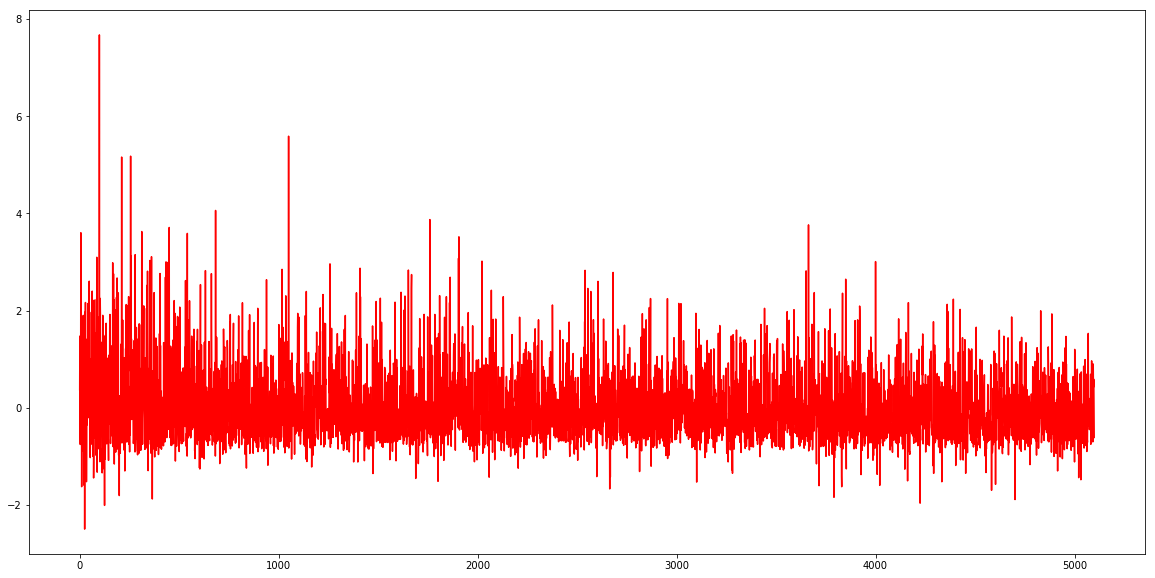

In [30]:
y_pred = model.predict(x)
diff = y - y_pred

plt.figure(figsize=(20, 10))
plt.plot(diff, color='red')

In [31]:
pd.DataFrame(np.hstack((y, y_pred)))

,0,1
0,1.14,0.769246
1,2.27,0.795833
2,0.46,0.805789
3,0.34,1.096659
4,1.80,1.633385
5,2.19,1.132522
6,4.89,1.289297
7,0.33,0.798059
8,2.04,1.426614
9,2.05,1.733666
